# Jupyter exploration and QC of AB1 chromatograms from a ZIP archive
## (for nerds who don't want to just blast it like a sane person)
#
#  - Opens the user‑supplied .zip of Sanger trace files
#  - Parses each *.ab1 into a Biopython SeqRecord
#  - Computes simple quality metrics (mean Phred, read length)
#  - Flags “bad” reads below thresholds
#  - Plots the raw electropherogram traces for any record you pick
#  - Saves a cleaned FASTA of “good” reads and a CSV QC table
#
#  👉  Before running, change ZIP_PATH to the correct location on your machine.
#  👉  The script assumes you’ve `pip install biopython pandas matplotlib`
#  👉  Runs remote BLAST via NCBI with your email embedded.

In [7]:
from pathlib import Path
import io, zipfile, time, re, textwrap, warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from Bio import SeqIO
from Bio.Blast import NCBIWWW, NCBIXML

ImportError: DLL load failed while importing _c_internal_utils: The specified module could not be found.

In [5]:
# ----------- USER CONFIGURATION --------------------------------------------
ZIP_PATH = Path(r"Grace_plate.zip")
EMAIL    = "m.nesbit19@imperial.ac.uk"

In [6]:
# QC thresholds
MIN_MEAN_PHRED = 20          # average read quality
MIN_READ_LEN   = 300         # length threshold (bp)

# BLAST options
BLAST_PROGRAM  = "blastn"
BLAST_DB       = "nt"
HITLIST_SIZE   = 50          # top hits to return
BLAST_EXPECT   = 1e-20       # E‑value threshold
WAIT_BETWEEN_JOBS = 3        # polite pause (s)
# ---------------------------------------------------------------------------

# Regular expression to capture a binomial species name (e.g. “Escherichia coli”)
SPECIES_PATTERN = re.compile(r"([A-Z][a-z]+\s[a-z]+)")

# helper functions


In [7]:
def ab1_records_in_zip(zip_path: Path):
    """Yield (member_name, SeqRecord) for every .ab1 inside the archive."""
    if not zip_path.exists():
        raise FileNotFoundError(f"{zip_path} not found – edit ZIP_PATH.")
    with zipfile.ZipFile(zip_path) as z:
        for member in z.namelist():
            if member.lower().endswith(".ab1"):
                with z.open(member) as handle:
                    data = io.BytesIO(handle.read())
                    for rec in SeqIO.parse(data, "abi"):
                        rec.id = Path(member).stem
                        rec.description = ""
                        yield member, rec

In [8]:
def mean_phred(rec):
    """Return the mean Phred quality of a SeqRecord (None if absent)."""
    q = rec.letter_annotations.get("phred_quality")
    return np.mean(q) if q else None

In [9]:
def classify_read(rec):
    """Return True/False depending on QC thresholds."""
    q = mean_phred(rec)
    return (q is not None and q >= MIN_MEAN_PHRED and len(rec) >= MIN_READ_LEN)

In [10]:
def qc_table(records):
    """Build a pandas DataFrame summarising QC metrics."""
    rows = []
    for name, rec in records:
        rows.append({
            "file": name,
            "id": rec.id,
            "length": len(rec),
            "mean_phred": mean_phred(rec),
            "status": "good" if classify_read(rec) else "bad"
        })
    return pd.DataFrame(rows)


In [11]:
def plot_chromatogram(rec, window=None, show=True):
    """
    Draw an electropherogram and optionally return (fig, ax) so callers
    can add labels before the figure is displayed.
    """
    raw = rec.annotations["abif_raw"]
    traces = [raw[f"DATA{i}"] for i in range(9, 13)]
    peak_pos = raw["PLOC1"]

    if window:
        s0 = max(0, peak_pos[window[0]] - 200)
        s1 = peak_pos[min(window[1], len(peak_pos)-1)] + 200
    else:
        s0, s1 = 0, len(traces[0])

    xs = np.arange(s0, s1)
    labels = ["G", "A", "T", "C"]

    fig, ax = plt.subplots(figsize=(12, 4))
    for ch, lab in zip(traces, labels):
        ax.plot(xs, ch[s0:s1], label=lab)

    ax.set_xlabel("sample")
    ax.set_ylabel("fluorescence")
    ax.legend(loc="upper right")
    ax.margins(x=0)

    if show:
        plt.show()

    return fig, ax


In [12]:
# --- Patch Biopython e-mail handling (run this cell) ------------------------
from Bio import Entrez
from Bio.Blast import NCBIWWW, NCBIXML   # <-- correct location

Entrez.email = EMAIL          # your contact address for NCBI

def run_blast_for_record(rec):
    """Submit one SeqRecord to NCBI BLAST and return a parsed XML record."""
    fasta = rec.format("fasta")
    handle = NCBIWWW.qblast(
        program      = BLAST_PROGRAM,   # "blastn"
        database     = BLAST_DB,        # "nt"
        sequence     = fasta,
        hitlist_size = HITLIST_SIZE,
        expect       = BLAST_EXPECT,
        megablast    = True,
        format_type  = "XML",
    )
    return NCBIXML.read(handle)

In [13]:
def parse_blast_record(record, asv_candidate_info):
    """Populate candidate info dict (similar logic to the user’s script)."""
    asv_id = record.query
    query_length = getattr(record, "query_length", None)
    asv_candidate_info.setdefault(asv_id, {})
    for aln in record.alignments:
        m = SPECIES_PATTERN.search(aln.hit_def)
        species = m.group(1) if m else "Species not identified"
        for hsp in aln.hsps:
            coverage = (hsp.align_length / query_length * 100) if query_length else None
            new = {
                "evalue":     hsp.expect,
                "bitscore":   hsp.bits,
                "coverage":   coverage,
                "align_len":  hsp.align_length,
                "identities": hsp.identities
            }
            best = asv_candidate_info[asv_id].get(species)
            if best is None or hsp.expect < best["evalue"]:
                asv_candidate_info[asv_id][species] = new

# Main workflow

In [14]:
print("🔍  Reading AB1 files from ZIP…")
records = list(ab1_records_in_zip(ZIP_PATH))
print(f"Found {len(records)} AB1 traces.")

🔍  Reading AB1 files from ZIP…
Found 96 AB1 traces.


In [15]:
# QC table
df_qc = qc_table(records)
good_mask = df_qc["status"] == "good"
print(f"{good_mask.sum()} good reads   |   { (~good_mask).sum()} bad reads")

61 good reads   |   35 bad reads


In [18]:
from ipydatagrid import DataGrid  # fall back to ipydatagrid
display(DataGrid(df_qc))

DataGrid(auto_fit_params={'area': 'all', 'padding': 30, 'numCols': None}, corner_renderer=None, default_render…

In [19]:
# Save good reads to FASTA for downstream BLAST (optional)
GOOD_FASTA = "good_reads.fasta"
with open(GOOD_FASTA, "w") as fasta_out:
    for (_, rec), status in zip(records, df_qc["status"]):
        if status == "good":
            SeqIO.write(rec, fasta_out, "fasta")
print(f"Saved good reads to {GOOD_FASTA}")

Saved good reads to good_reads.fasta


In [20]:
print(f"Total SeqRecords parsed: {len(records)}")
print(df_qc["status"].value_counts())        # how many GOOD / BAD?

Total SeqRecords parsed: 96
status
good    61
bad     35
Name: count, dtype: int64


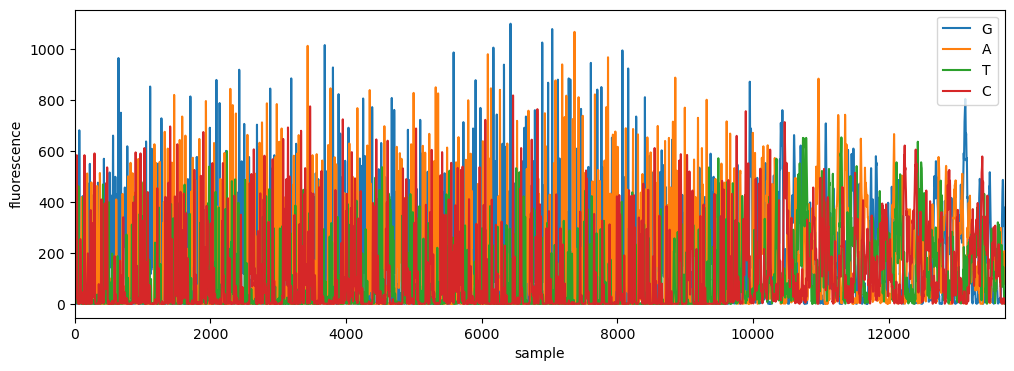

(<Figure size 1200x400 with 1 Axes>,
 <Axes: xlabel='sample', ylabel='fluorescence'>)

In [21]:
# pick the very first record, plot the entire read
plot_chromatogram(records[0][1], window=None)

In [22]:
from ipywidgets import interact, Dropdown

rec_map = {r.id: r for _, r in records}
qc_map  = dict(zip(df_qc.id, df_qc.status))

WINDOW = None        # or None for full trace

def view_trace(rec_id):
    rec = rec_map[rec_id]
    qc  = qc_map[rec_id]
    colour = "green" if qc == "good" else "red"

    fig, ax = plot_chromatogram(rec, window=WINDOW, show=False)

    # big coloured title
    ax.set_title(f"{rec_id} — {qc.upper()}",
                 color=colour, weight="bold", fontsize=14)

    # badge in the corner (optional eye-catcher)
    ax.text(0.01, 0.97, qc.upper(),
            transform=ax.transAxes,
            va="top", ha="left",
            color="white",
            fontsize=12, weight="bold",
            bbox=dict(facecolor=colour, edgecolor="none", alpha=0.85))

    plt.show()           # finally display the figure

interact(
    view_trace,
    rec_id=Dropdown(options=sorted(rec_map), description="Record:")
)

interactive(children=(Dropdown(description='Record:', options=('A1-UB27f', 'A10-UB27f', 'A11-UB27f', 'A12-UB27…

<function __main__.view_trace(rec_id)>

In [23]:
# --- Blast the good reads ---------------------------------------------------
print("\n🚀  Running BLAST (remote) on good reads – this will take a while…")
asv_candidate_info = {}
for (_, rec), status in zip(records, df_qc["status"]):
    if status == "good":
        print(f"BLASTing {rec.id} ({len(rec)} bp)…")
        br = run_blast_for_record(rec)
        parse_blast_record(br, asv_candidate_info)
        time.sleep(WAIT_BETWEEN_JOBS)


🚀  Running BLAST (remote) on good reads – this will take a while…
BLASTing A1-UB27f (1147 bp)…
BLASTing A2-UB27f (1240 bp)…
BLASTing A3-UB27f (1346 bp)…
BLASTing A6-UB27f (962 bp)…
BLASTing A10-UB27f (1305 bp)…
BLASTing A11-UB27f (1193 bp)…
BLASTing A12-UB27f (1218 bp)…
BLASTing B1-UB27f (1232 bp)…
BLASTing B2-UB27f (1325 bp)…
BLASTing B8-UB27f (721 bp)…
BLASTing B11-UB27f (1535 bp)…
BLASTing C2-UB27f (1323 bp)…
BLASTing C5-UB27f (1532 bp)…
BLASTing C6-UB27f (1378 bp)…
BLASTing C8-UB27f (1352 bp)…
BLASTing C11-UB27f (1215 bp)…
BLASTing D1-UB27f (1265 bp)…
BLASTing D2-UB27f (1200 bp)…
BLASTing D7-UB27f (1074 bp)…
BLASTing D9-UB27f (1381 bp)…
BLASTing D12-UB27f (1154 bp)…
BLASTing E1-UB27f (1287 bp)…
BLASTing E2-UB27f (1292 bp)…
BLASTing E3-UB27f (1383 bp)…
BLASTing E4-UB27f (1392 bp)…
BLASTing E6-UB27f (1323 bp)…
BLASTing E7-UB27f (1365 bp)…
BLASTing E11-UB27f (1165 bp)…
BLASTing E12-UB27f (1231 bp)…
BLASTing F4-UB27f (996 bp)…
BLASTing F5-UB27f (1324 bp)…
BLASTing F6-UB27f (1367 bp)…


In [24]:
# ---------------------------------------------------------------------------
# Summarise BLAST candidates  ➜  CSV  +  DataFrame (with sequences included)
# ---------------------------------------------------------------------------
CSV_OUT = "id_candidate_info.csv"

# map ID → sequence string (one-liner, works even if you trimmed reads earlier)
seq_map = {rec.id: str(rec.seq) for _, rec in records}

rows = []
for asv_id, sp_dict in asv_candidate_info.items():
    for species, m in sp_dict.items():
        rows.append({
            "ID": asv_id,
            "Sequence":   seq_map.get(asv_id, ""),                # NEW COLUMN
            "Species":    species,
            "E-value":    m["evalue"],
            "Bitscore":   m["bitscore"],
            "Coverage (%)": (f"{m['coverage']:.2f}" if m["coverage"] else "NA"),
            "Alignment Length": m["align_len"],
            "Identities": m["identities"],
        })

field_order = [
    "ID", "Sequence", "Species", "E-value", "Bitscore",
    "Coverage (%)", "Alignment Length", "Identities"
]
df_out = pd.DataFrame(rows, columns=field_order)

# write to disk
df_out.to_csv(CSV_OUT, index=False)
print(f"✔️  Summary (with sequences) written to {CSV_OUT}")

# show every row / column in notebook output
pd.set_option("display.max_rows", None)      # no row limit
pd.set_option("display.max_columns", None)   # show all columns
pd.set_option("display.width", None)         # don’t wrap lines

display(df_out)                              # now renders the entire table



✔️  Summary (with sequences) written to id_candidate_info.csv


,ID,Sequence,Species,E-value,Bitscore,Coverage (%),Alignment Length,Identities
0,A1-UB27f,ACCATGCAAGTCGAACGGCAGCACAGAGGAGCTTGCTCCTTGTGGT...,Stenotrophomonas maltophilia,0.000000e+00,1646.490,86.22,989,959
1,A1-UB27f,ACCATGCAAGTCGAACGGCAGCACAGAGGAGCTTGCTCCTTGTGGT...,Stenotrophomonas sp,0.000000e+00,1642.790,86.05,987,957
2,A1-UB27f,ACCATGCAAGTCGAACGGCAGCACAGAGGAGCTTGCTCCTTGTGGT...,Species not identified,0.000000e+00,1642.790,86.05,987,957
3,A1-UB27f,ACCATGCAAGTCGAACGGCAGCACAGAGGAGCTTGCTCCTTGTGGT...,Stenotrophomonas muris,0.000000e+00,1642.790,86.05,987,957
4,A1-UB27f,ACCATGCAAGTCGAACGGCAGCACAGAGGAGCTTGCTCCTTGTGGT...,Uncultured bacterium,0.000000e+00,1642.790,86.05,987,957
5,A1-UB27f,ACCATGCAAGTCGAACGGCAGCACAGAGGAGCTTGCTCCTTGTGGT...,Pseudomonas hibiscicola,0.000000e+00,1642.790,86.05,987,957
6,A1-UB27f,ACCATGCAAGTCGAACGGCAGCACAGAGGAGCTTGCTCCTTGTGGT...,Stenotrophomonas geniculata,0.000000e+00,1642.790,86.05,987,957
7,A1-UB27f,ACCATGCAAGTCGAACGGCAGCACAGAGGAGCTTGCTCCTTGTGGT...,Pseudomonas sp,0.000000e+00,1637.250,86.05,987,956
8,A1-UB27f,ACCATGCAAGTCGAACGGCAGCACAGAGGAGCTTGCTCCTTGTGGT...,Bacterium strain,0.000000e+00,1637.250,86.05,987,956
9,A2-UB27f,GGGTGGCTACACATGCAAGTCGAACGGCAGCACAGAGGAGCTTGCT...,Stenotrophomonas maltophilia,0.000000e+00,2026.890,97.98,1215,1177


# tada done